# Analýza nákupního košíku
## Import a příprava dat 
### Import

In [2]:
import pyreadstat #Import knihovny pyreadstat pro otevření sav souboru
df, meta = pyreadstat.read_sav('Shopping_items.sav')  #Načte .sav file
df #Zobrazení naimportovaných dat

,ID,ITEM
0,1.0,READMADE
1,1.0,SNACKS
2,2.0,READMADE
3,2.0,TOILETRY
4,3.0,READMADE
...,...,...
2390,784.0,ALCOHOL
2391,785.0,FROZEN
2392,785.0,ALCOHOL
2393,785.0,SNACKS


### Příprava dat do košíků - Vytvoření pole košíků

In [3]:
kosikID = 1 #ID prvního košíku
kosiky = [] #Inicializace prázdného listu košíků
kosik = [] #Inicializace práždného košíku
for row in df.values: #For cyklus který prochází dataframe a třidí záznamy do košíků
    if kosikID != row[0]: #Podmínka pro vytvoření nového košíku
        kosikID = row[0] #Přířazení nového ID košíku
        kosiky.append(kosik) #Přidání předchozího košíku do listu košíku
        kosik = [] #Vyprázdnění košíku 
    kosik.append(row[1]) #Přidání položky do košíku
print("Příklad přvních tří košíků \n", kosiky[0],"\n", kosiky[1],"\n", kosiky [2]) #Ukázkový print

Příklad přvních tří košíků 
 ['READMADE', 'SNACKS'] 
 ['READMADE', 'TOILETRY'] 
 ['READMADE', 'TOILETRY', 'SNACKS']


### Vytvoření DataFrame příznaků

In [4]:
import pandas as pd #Import knihovny pandas pro práci s dataframy
from mlxtend.preprocessing import TransactionEncoder #Import TransactionEncoderu z knihovny mlxtend.preprocesing 
te = TransactionEncoder() #Inicializace TransactionEncoderu
te_array = te.fit(kosiky).transform(kosiky) #Vytvoření matice příznaků
priznaky = pd.DataFrame(te_array, columns = te.columns_) # Vytvoření dataFramu z matice příznaků
priznaky #Ukázka dataframu

,ALCOHOL,BAKERY,FROZEN,MEAT,MILK,READMADE,SNACKS,TINNED,TOILETRY,VEG
0,False,False,False,False,False,True,True,False,False,False
1,False,False,False,False,False,True,False,False,True,False
2,False,False,False,False,False,True,True,False,True,False
3,False,True,False,False,True,True,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
780,True,False,True,False,False,False,False,True,True,False
781,True,False,False,False,False,False,False,False,False,False
782,False,True,True,False,False,True,True,False,False,False
783,True,False,False,False,False,False,False,False,False,False


## Porozumění datům
### Procentuální zastoupení položek v košíkách

In [5]:
pocty = df.groupby('ITEM').ID.nunique() #Počty jednotlivých položek 
pocet_kosiku = len(df.groupby('ID').ITEM.nunique().index) #Počet košíků
procenta = [] #Inicializace pole pro procenta
for items in pocty.values: #Výpočet procentuálního zastoupení
    procenta.append(round(items/pocet_kosiku*100,1)) #Přidání do pole pro procenta

tabulka = df.groupby('ITEM').nunique()
tabulka.insert(1, "Procenta", procenta, True)
tabulka = tabulka.rename(columns= {'ID':'Počet'})
tabulka

,Počet,Procenta
ITEM,,
ALCOHOL,310,39.4
BAKERY,337,42.9
FROZEN,316,40.2
MEAT,23,2.9
MILK,148,18.8
READMADE,387,49.2
SNACKS,373,47.5
TINNED,358,45.5
TOILETRY,78,9.9


### Distribuce

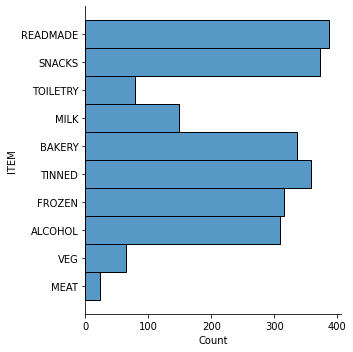

In [6]:
import seaborn as sns #Import knihovny pro vykreslování grafů
sns.displot(df,y="ITEM") #Distribuce jednotlivých druhů zboží

### Web Graph

In [7]:
from pyvis import network as net #Importuje knihovnu pro kreslení grafů
import numpy as np #Numerická knihovna pythonu
g = net.Network(notebook=True) #Vytvoří objekt pro kreslení grafu
col = ['#4f340b','#93694c','#07134f','#8d73c4','#8807bf','#30253d','#638e83','#470be0','#12231f','#706d6e'] #Seznam barev pro body
pocet_polozek = len(pocty.index.values) #Počet skupin
g.add_nodes(pocty.index.values, size=10*np.ones(pocet_polozek), color = col) #Přidání skupin na plátno
size = pocet_polozek*pocet_polozek #Výpočet velikosti množiny vztahů
mat = np.array([0]*size).reshape(pocet_polozek,pocet_polozek) #Alokace množiny vztahů
dc = {'ALCOHOL':0,'BAKERY':1,'FROZEN':2, 'MEAT':3,'MILK':4, 'READMADE':5,'SNACKS':6,'TINNED':7,'TOILETRY':8,'VEG':9} #Slovník pro jednoduché přiřazení indexu k názvu
inv_dc = {v: k for k, v in dc.items()} #Inverzní slovník

for row in kosiky: #Projde všechny košíky
    for i in range(len(row)): #Projde košík po prvcích - každý s každým
        j= i + 1 #Výpočet indexu zbytku košíku
        while j < len(row): #Dokud je ješě něco v košíku procházej dál
            mat[dc[row[i]]][dc[row[j]]] += 1 #Přičtení do matice vztahů
            j+=1 #Iterace indexu vnitřního cyklu

for i in range(len(mat)): #Cyklus pro vytvoření vztahů mezi body
    for j in range(len(mat)): #Projde prvky matice závislotí
        if mat[i][j] != 0: # Pokud je nenulová přidej hranu
            g.add_edge(inv_dc[i],inv_dc[j],value=mat[i][j].item(),length=500) #Přidání hrany délky 500 a velikosti z matice vztahů
#g.show_buttons() #Posuvníky pro nastavení
#Nastavení pro hezký graf
g.set_options('var options = {"nodes": {"font": {"size": 25,"strokeWidth": 4}},"edges": {"color": {"highlight": "rgb(46,139,87)","color": "rgba(6,64,201,0.6)","inherit": false},"hoverWidth": 2,"scaling": {"max": 7},"smooth": false},"physics": {"barnesHut": {"damping": 0.95},"minVelocity": 0.75}}')
g.show('web.html') #Vykreslí html stránku s grafem

## Modelování
### Generování frekventovaných množin

In [23]:
from mlxtend.frequent_patterns import apriori #Import apriori algoritmu
frequent_itemsets = apriori(priznaky, min_support=0.08, use_colnames=True) #Vytvoření frekventovaných množim z matice přiznaků
frequent_itemsets_doporuceni = apriori(priznaky, min_support=0.1, use_colnames=True) #Frekventované množiny pro doporučení
frequent_itemsets #Ukázka frekventovaných množin

,support,itemsets
0,0.394904,(ALCOHOL)
1,0.429299,(BAKERY)
2,0.401274,(FROZEN)
3,0.188535,(MILK)
4,0.492994,(READMADE)
...,...,...
73,0.089172,"(BAKERY, READMADE, SNACKS, FROZEN)"
74,0.099363,"(BAKERY, READMADE, TINNED, FROZEN)"
75,0.094268,"(BAKERY, TINNED, SNACKS, FROZEN)"
76,0.098089,"(BAKERY, READMADE, SNACKS, TINNED)"


## Vytvoření asociačních pravidel

In [24]:
from mlxtend.frequent_patterns import association_rules #Import knihovny asociáčních pravidel
res = association_rules(frequent_itemsets, metric="confidence",min_threshold=0.7) #Aplikování asociačních pravidel na frekventované množiny, kde je  Confidence větši než 70% (stejné nastavení jsme použili v modeleru pro Apriori)
res = res.sort_values(by=['confidence'], ascending=False,ignore_index=True) #Seřazení výsledku od nejvyšší confidence
alc = res[res['consequents'] == {'ALCOHOL'}] #Omezení množiny pravidel
res_doporuceni = association_rules(frequent_itemsets_doporuceni, metric="confidence",min_threshold=0.5) #Aplikování asociačních pravidel na frekventované množiny, kde je  Confidence větši než 50% (stejné nastavení jsme použili v modeleru pro CARMU)
res_doporuceni = res_doporuceni.sort_values(by=['confidence'], ascending=False,ignore_index=True) #Seřazení výsledku od nejvyšší confidence

alc #Ukázka pravidel pro doporučení alkoholu

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
11,"(MILK, FROZEN)",(ALCOHOL),0.108280,0.394904,0.084076,0.776471,1.966224,0.041316,2.707006
14,"(READMADE, SNACKS, FROZEN)",(ALCOHOL),0.127389,0.394904,0.096815,0.760000,1.924516,0.046509,2.521231
21,"(BAKERY, READMADE, FROZEN)",(ALCOHOL),0.138854,0.394904,0.104459,0.752294,1.905001,0.049625,2.442793
35,"(READMADE, FROZEN, TINNED)",(ALCOHOL),0.126115,0.394904,0.090446,0.717172,1.816064,0.040643,2.139445
42,"(FROZEN, SNACKS, TINNED)",(ALCOHOL),0.114650,0.394904,0.081529,0.711111,1.800717,0.036253,2.094561
47,"(BAKERY, SNACKS, FROZEN)",(ALCOHOL),0.136306,0.394904,0.095541,0.700935,1.774947,0.041714,2.023288


## Nasazení
### Pokladna

In [10]:
kosik = frozenset(['MILK', 'TINNED','READMADE']) #Nákupní košík
i = 1 #Index doporučení
out = [] #Výsledek - doporučené skupiny zboží
for row in res_doporuceni.values:#For cyklus hledající v asociačních pravidlech
    #Pokud je předpoklad(antecedent) podmnožinou košíku a závěr(Consequent) není ještě doporučený a ani v kokšíku
    if (row[0].issubset(kosik) and not(row[1].issubset(frozenset(out))) and not(row[1].issubset(kosik))): 
        out.append(list(row[1])[0]) #Přidá doporučení do výstupu OUT
        print(i,". Nechcete také koupit:",list(row[1])[0],"| Confidence:",row[5]) #Vytiskne doporučení a jeho confidence
        i += 1 #Zvedni index doporučení
    if (i == 4): #Pokud už jsou 3 položky 
        break #ukonči hledání

1 . Nechcete také koupit: BAKERY | Confidence: 0.7904761904761906
2 . Nechcete také koupit: SNACKS | Confidence: 0.6621621621621621
3 . Nechcete také koupit: ALCOHOL | Confidence: 0.6081081081081081


### Doporučení alkoholu

In [11]:
kosik = frozenset(['FROZEN', 'MILK']) #Nákupní košík 
for row in alc.values: #Projde asociační pravidla
    if(row[0].issubset(kosik)) and not(row[1].issubset(kosik)): #Pokud je pravidlo podmnožinou košíku a není v košíku alkohl
        print("Nechcete ještě alkohol?") #Doporučí alkohol
        break #Ukonční cyklus

Nechcete ještě alkohol?
